# Project Name: Lyric Generator
Description:
Implementing a Deep Neural network using LSTMs to create a character based lyric generator

Details:
1. step size: 40
2. batch size: 128
3. Epochs: 100
4. Songs: 1000

### Importing Libraries

In [1]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Activation,LSTM,Dense,CuDNNLSTM, Flatten, Bidirectional, Dropout
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
import os
import matplotlib.pyplot as plt
import math
np.random.seed(10)
import pickle

Using TensorFlow backend.


### Design Parameters

In [2]:
BATCH_SIZE = 128
maxlen = 40 ##timesteps
epochs = 10
# MIN_WORD_FREQUENCY = 10
song_count = 100

In [3]:
def load_lyrics(path):
    '''
    Function to load lyrics of all the artists in the input path
    '''
    lyrics = ""
    for fn in os.listdir(path):
        with open(os.path.join(path, fn), 'r') as song:
            song_lyrics = clean_string(song.read())
            lyrics += song_lyrics
    return lyrics

def clean_string(string):
    """
    Cleans unwanted characters and words from string.
    @param string: The string to be cleaned.
    @return: The cleaned string.
    """
    string = string.lower()  # lowercase

    clean_words = []
    for word in string.split():
        # clean words with quotation marks on only one side
        if word[0] == '"' and word[-1] != '"':
            word = word[1:]
        elif word[-1] == '"' and word[0] != '"':
            word = word[-1]

        # clean words with parenthases on only one side
        if word[0] == '(' and word[-1] != ')':
            word = word[1:]
        elif word[-1] == ')' and word[0] != '(':
            word = word[:-1]

        clean_words.append(word)
    return ' '.join(clean_words)

### Reading Input
Parameters: 10 songs

In [4]:
# ## Reading the scraped Rap songs
# text = load_lyrics("./RapLyrics-Scraper/my_lyrics_folder/")

In [5]:
## Reading the kaggle input ~55k songs
df=pd.read_csv('../songdata.csv')['text'][:song_count]
data=np.array(df)

In [6]:
# ## Reading the scraped pink floyed songs
# df=pd.read_csv('./pink_floyd_lyrics.csv',header=0, error_bad_lines=False, delimiter='\t')['text']
# df = df.fillna('')
# data=np.array(df)

### Creating corpus(all the characters in all the songs concatenated)
1. Converting all the characters to lower

In [7]:
corpus=''
for ix in range(len(data)):
    corpus+=data[ix]
corpus = corpus.lower()
corpus = clean_string(corpus)
# corpus = text

### Creating Vocabulary and char, index mappings

In [8]:
vocab=list(set(corpus))
char_ix={c:i for i,c in enumerate(vocab)}
ix_char={i:c for i,c in enumerate(vocab)}

### Setting up the timesteps

In [9]:
vocab_size=len(vocab) ##Dimensions of each char
print(vocab_size)
print(vocab)

41
['k', 'x', ']', ' ', 'w', 'f', 'a', 'e', '?', "'", 'd', 'm', 'v', 'r', ')', 'g', ',', 't', 's', 'o', 'h', 'n', '"', 'c', 'y', 'i', '-', 'l', 'q', 'b', 'z', 'j', '[', '2', '4', '.', ':', 'p', 'u', '(', '!']


In [10]:
len(corpus)

124337

### Creating the train and test datasets

In [11]:
sentences=[]
next_char=[]
for i in range(len(corpus)-maxlen-1):
    sentences.append(corpus[i:i+maxlen])
    next_char.append(corpus[i+maxlen])
split_count = int(0.8 * len(corpus))
sentences_test = sentences[split_count:]
next_char_test = next_char[split_count:]
sentences = sentences[:split_count]
next_char = next_char[:split_count]

In [12]:
def generator(sentence_list, next_word_list, batch_size):
    '''
    Generator function to generate the input/output data using
    generators concept(to avoid RAM overflow)
    '''
    index = 0
    while True:
        x = np.zeros((batch_size, maxlen, vocab_size), dtype=np.bool)
        y = np.zeros((batch_size, vocab_size), dtype=np.bool)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index]):
                x[i, t, char_ix[w]] = 1
            y[i, char_ix[next_word_list[index]]] = 1

            index = index + 1
            if index == len(sentence_list):
                index = 0
        yield x, y

In [13]:
def create_model(timesteps, vocab_size, no_layers=2):
    '''
    Creating the model
    '''
    model=Sequential()
    model.add(CuDNNLSTM(128,input_shape=(timesteps,vocab_size)))
#     for i in range(no_layers):
#         model.add(Bidirectional(CuDNNLSTM(128,input_shape=(timesteps,vocab_size), return_sequences=True)))
#     model.add(Flatten())
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    model.summary()
    model.compile(optimizer=Adam(lr=0.01),loss='categorical_crossentropy')
    return model

In [14]:
model = create_model(maxlen, vocab_size)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               87552     
_________________________________________________________________
dense_1 (Dense)              (None, 41)                5289      
_________________________________________________________________
activation_1 (Activation)    (None, 41)                0         
Total params: 92,841
Trainable params: 92,841
Non-trainable params: 0
_________________________________________________________________


In [15]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    '''
    Callback function to write output to file after each epoch
    '''
    # Function invoked at end of each epoch. Prints generated text.
    examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)

    # Randomly pick a seed sequence
    seed_index = np.random.randint(len(sentences+sentences_test))
    seed = (sentences+sentences_test)[seed_index]

    for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
        sentence = seed
        examples_file.write('----- Diversity:' + str(diversity) + '\n')
        examples_file.write('----- Generating with seed:\n"' + ' '.join(sentence) + '"\n')
        examples_file.write(' '.join(sentence))

        for i in range(50):
            x_pred = np.zeros((1, maxlen, vocab_size))
            for t, word in enumerate(sentence):
                x_pred[0, t,char_ix[word]] = 1

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char_pred = ix_char[next_index]

            sentence = sentence[1:]
#             print(sentence)
            sentence += next_char_pred

            examples_file.write(" "+next_char_pred)
        examples_file.write('\n')
    examples_file.write('='*80 + '\n')
#     examples_file.flush()

### Opening the output file

In [16]:
examples_file = open("output_data.txt", "w")

### Training the model

In [17]:
file_path = "./checkpoints/LSTM_LYRICS-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-loss{loss:.4f}-acc{acc:.4f}-val_loss{val_loss:.4f}-val_acc{val_acc:.4f}" % (
    len(vocab),
    maxlen,
    10
)
# checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True)

# checkpoint_path = "cp.ckpt"
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_weights_only=True,
#                                                  verbose=1)

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list = [print_callback]
# history = model.fit_generator(generator(sentences, next_char, BATCH_SIZE),
#     steps_per_epoch=int(len(sentences)/BATCH_SIZE) + 1,
#     epochs=epochs,
#     validation_data=generator(sentences_test, next_char_test, BATCH_SIZE),
#     validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1,
#     callbacks = callbacks_list
#     )

### Closing the output file

In [18]:
examples_file.close()

### Plotting Train Loss curve

In [19]:
plt.plot(history.history['loss'])

NameError: name 'history' is not defined

NameError: name 'history' is not defined

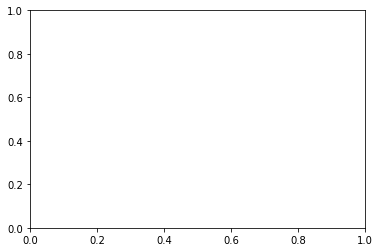

In [20]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
plt.plot(history.history['loss'])
fig.savefig('Train_loss.png')   # save the figure to file
plt.close(fig)    # close the figure

### Plotting Validation Loss curve

In [21]:
plt.plot(history.history['val_loss'])

NameError: name 'history' is not defined

NameError: name 'history' is not defined

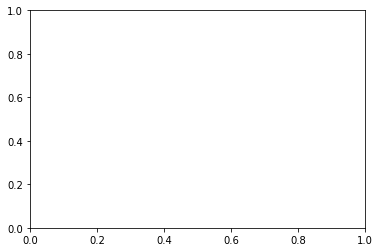

In [22]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
plt.plot(history.history['val_loss'])
fig.savefig('Val_loss.png')   # save the figure to file
plt.close(fig)    # close the figure

### Saving the model to disk

In [26]:
# model.save('keras_model_char.hdf5')
path = "/home/iwonttellyouthat/lyric_generator/char_based/results/models/LSTM_40_1_128.pickle"
# model = keras.models.load_model(path)
with open(path, 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
del model

### Loading the model

In [23]:
#loaded_model = keras.models.load_model('keras_model.hdf5')
path = "/home/iwonttellyouthat/lyric_generator/char_based/results/models/LSTM_40_1_128.pickle"
with open(path, 'rb') as handle:
    model = pickle.load(handle)

Instructions for updating:
Use tf.cast instead.


In [24]:
def sample(preds, temperature=1.0):
    '''
    Function to sample a character from the a given
    list of probs
    '''
#     preds = np.cumsum(preds)
#     rng = np.random()
#     for i in range(preds):
#         if preds[i]>rng:
#             return i
#     return len(preds)-1
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Testing the model

In [25]:
# Randomly pick a seed sequence
# seed_index = np.random.randint(len(sentences_test))
# seed = sentences_test[seed_index]
seed_index = -150
seed = corpus[-seed_index:-seed_index+maxlen]
print("----- Actual")
print(corpus[-seed_index:-seed_index+maxlen+100])
print()

for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
    sentence = seed
    print('----- Diversity:' + str(diversity) + '\n')
    print('----- Generating with seed:\n"' + ''.join(sentence) + '"\n')
    print(''.join(sentence))

    for i in range(100):
        x_pred = np.zeros((1, maxlen, vocab_size))
        for t, word in enumerate(sentence):
            x_pred[0, t,char_ix[word]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char_pred = ix_char[next_index]

        sentence = sentence[1:]
#             print(sentence)
        sentence += next_char_pred

        print(""+next_char_pred, end="")
    print('\n')
print('='*80 + '\n')

----- Actual
 be? she's just my kind of girl, she makes me feel fine who could ever believe that she could be mine? she's just my kind of girl, without h

----- Diversity:0.3

----- Generating with seed:
" be? she's just my kind of girl, she mak"

 be? she's just my kind of girl, she mak
[nq.h[knckw4kno4k[ yk!q.k)k!q.khcko4qmkycs?m4kvc.4kno4k[s.k)k!q.khck[o4kxcsfhkvck4f[k)nkqffkno4kmc! 

----- Diversity:0.4

----- Generating with seed:
" be? she's just my kind of girl, she mak"

 be? she's just my kind of girl, she mak
oqmhknoqnkycs?m4kvc.4knckl4kx)nocsnkno4kmcm.).vk:s44.k[ckno4kmc! ?.kmcffkw4knoqnkycskhc.?nk[nczkhc.?

----- Diversity:0.5

----- Generating with seed:
" be? she's just my kind of girl, she mak"

 be? she's just my kind of girl, she mak
[ck!q[[4kno4kfcb4kycs?m4kvc..qkl4k[cw4no).vk[z4!)qfkfcb4k)[kqktm)4.hkno4kmc! ?.kmcffknckl4kxo4.knoqn

----- Diversity:0.6

----- Generating with seed:
" be? she's just my kind of girl, she mak"

 be? she's just my kind of girl, she mak
[sm

### Testing the model

In [ ]:
# txt = corpus
# start_index = 230

generated = ''
actual = ''
# sent=txt[start_index:start_index+maxlen]
sent = sentences_test[0]
generated += sent
actual += sent
print("Input - ",generated)
gen = generated
for i in range(100):
    x_sample=generated[i:i+maxlen]
    x = np.zeros((1,maxlen,vocab_size))
    for j in range(maxlen):
        x[0,j,char_ix[x_sample[j]]] = 1
    probs = model.predict(x)
    probs = np.reshape(probs,probs.shape[1])
#     ix = np.argmax(probs)
    ix=np.random.choice(range(vocab_size),p=probs.ravel())
    generated += ix_char[ix]
    actual += next_char_test[i]
# for i in range(100):
#     x_sample=gen[i:i+maxlen]
#     x=np.zeros((1,maxlen,vocab_size))
#     for j in range(maxlen):
#         x[0,j,char_ix[x_sample[j]]]=1
#     probs=loaded_model.predict(x)[0]
#     ix = np.argmax(probs)
# #     ix=np.random.choice(range(vocab_size),p=probs.ravel())
#     gen+=ix_char[ix]
# # print("--------------")

In [ ]:
print("Generated - ")
print(generated)
print()
print("Actual -")
print(actual)

### Credits